<a href="https://colab.research.google.com/github/jananibabu3/Autonomous-warehouse-robot-using-computer-vision/blob/main/Group_Assignment_2_modern_data_science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812365 sha256=18a0138b9fe4852a240f037d6d06ecf6bbbdb6660b59ebd8cfe1c5d07f44e841
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


In [3]:
!pip install pyspark
import pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812365 sha256=1107bc5dd858fdf9d885d87dfa96d44827c611c53b17efb4fc5877644f551599
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when


In [5]:
#  Start a Spark session
spark = SparkSession.builder.appName("TransactionRecord").getOrCreate()


In [6]:
# Load the CSV data from Google Drive
file_path = "/content/drive/MyDrive/transactionrecord.gz"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Display schema and initial data to verify
df.printSchema()
df.show(5)

root
 |-- TransactionNo: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- ProductNo: string (nullable = true)
 |-- ProductName: string (nullable = true)
 |-- Product_category: string (nullable = true)
 |-- Price: double (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- CustomerNo: integer (nullable = true)
 |-- Country: string (nullable = true)

+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+
|TransactionNo|     Date|ProductNo|         ProductName|Product_category|Price|Quantity|CustomerNo|       Country|
+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+
|       581482|12/9/2019|    22485|Set Of 2 Wooden M...|             0ca|21.47|      12|     17490|United Kingdom|
|       581475|12/9/2019|    22596|Christmas Star Wi...|             0ca|10.65|      36|     13069|United Kingdom|
|       581475|12/9/2019|    23235|Storage Tin

Part 1
Question 1.1

Q 1.1.1

In [7]:
# Replace 'null' in the 'CustomerNo' column with '-1'
df_cleaned = df.withColumn('CustomerNo', when(df['CustomerNo'].isNull(), '-1').otherwise(df['CustomerNo']))

1.1.2

In [8]:
from pyspark.sql.functions import regexp_replace

# Step 1: Process the 'ProductName' column to keep only alphabetic characters (removing non-alphabet characters)
df_cleaned = df_cleaned.withColumn("productName_process", regexp_replace(df_cleaned["ProductName"], "[^A-Za-z]", ""))

# Step 2: Show the first 5 rows of the DataFrame with the new 'productName_process' column
df_cleaned.select("ProductName", "productName_process").show(5)

+--------------------+--------------------+
|         ProductName| productName_process|
+--------------------+--------------------+
|Set Of 2 Wooden M...|SetOfWoodenMarket...|
|Christmas Star Wi...|ChristmasStarWish...|
|Storage Tin Vinta...|StorageTinVintage...|
|Tree T-Light Hold...|TreeTLightHolderW...|
|Set Of 4 Knick Kn...|SetOfKnickKnackTi...|
+--------------------+--------------------+
only showing top 5 rows



Question 1.2

Q 1.2.1

In [9]:
from pyspark.sql.functions import col

# Calculate the revenue by multiplying 'Price' and 'Quantity', saving it as a new column 'Revenue'
df_cleaned = df_cleaned.withColumn("Revenue", (col("Price") * col("Quantity")).cast("float"))

# Show the top 5 rows with the new 'Revenue' column
df_cleaned.select("TransactionNo", "Date", "Price", "Quantity", "Revenue").show(5)

+-------------+---------+-----+--------+-------+
|TransactionNo|     Date|Price|Quantity|Revenue|
+-------------+---------+-----+--------+-------+
|       581482|12/9/2019|21.47|      12| 257.64|
|       581475|12/9/2019|10.65|      36|  383.4|
|       581475|12/9/2019|11.53|      12| 138.36|
|       581475|12/9/2019|10.65|      12|  127.8|
|       581475|12/9/2019|11.94|       6|  71.64|
+-------------+---------+-----+--------+-------+
only showing top 5 rows



Q1.2.2

In [10]:
# Convert the PySpark DataFrame to a Pandas DataFrame
df_pandas = df_cleaned.toPandas()

# Convert the 'Date' column to a proper datetime format and create the 'transaction_date' column
import pandas as pd

df_pandas['transaction_date'] = pd.to_datetime(df_pandas['Date'], format='%m/%d/%Y')

# Show the top 5 rows of the Pandas DataFrame with the new 'transaction_date' column
print(df_pandas[['TransactionNo', 'Date', 'transaction_date']].head())

  TransactionNo       Date transaction_date
0        581482  12/9/2019       2019-12-09
1        581475  12/9/2019       2019-12-09
2        581475  12/9/2019       2019-12-09
3        581475  12/9/2019       2019-12-09
4        581475  12/9/2019       2019-12-09


Q 1.2.3

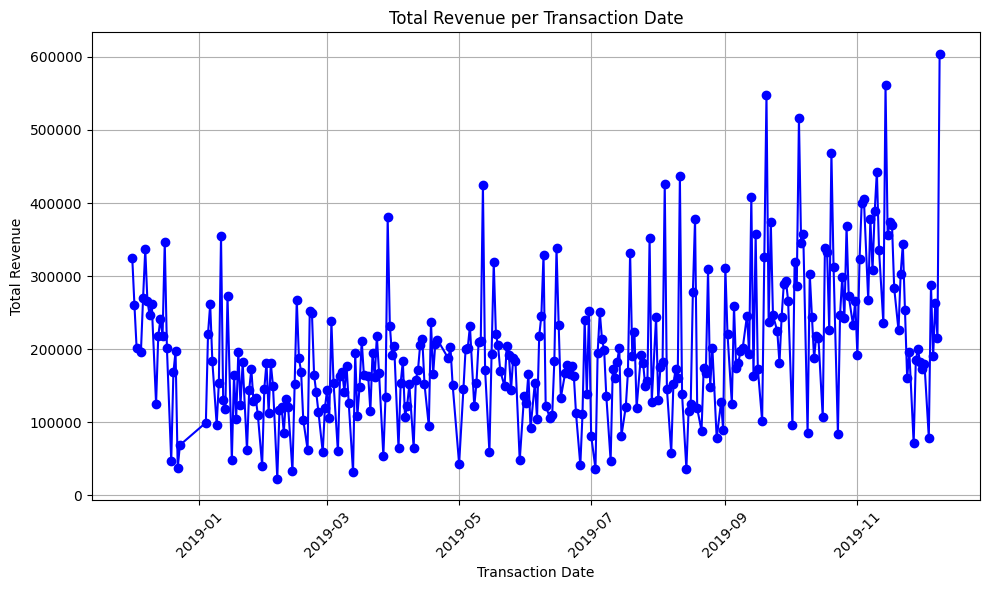

In [11]:
# Import necessary plotting libraries
import matplotlib.pyplot as plt

# Group the data by 'transaction_date' and sum the 'Revenue'
revenue_by_date = df_pandas.groupby('transaction_date')['Revenue'].sum()

# Plot the summed revenue against the transaction date in a line plot
plt.figure(figsize=(10, 6))
plt.plot(revenue_by_date.index, revenue_by_date.values, marker='o', linestyle='-', color='b')
plt.title('Total Revenue per Transaction Date')
plt.xlabel('Transaction Date')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


Q 1.3

1.3.1

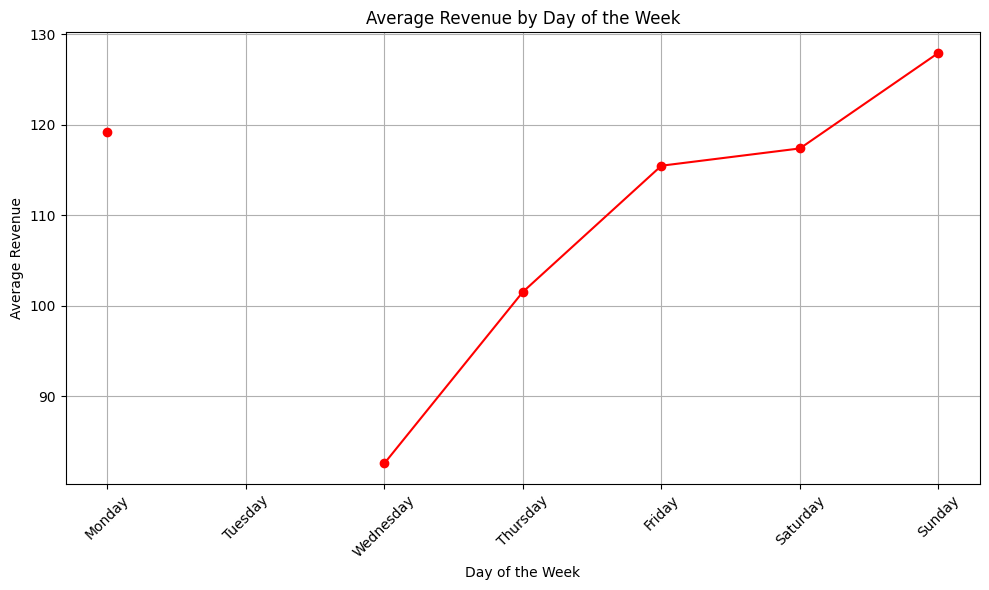

In [12]:
# Extract the day of the week from the 'transaction_date'
df_pandas['day_of_week'] = df_pandas['transaction_date'].dt.day_name()

# Calculate average revenue for each day of the week
average_revenue_by_day = df_pandas.groupby('day_of_week')['Revenue'].mean()

# Ensure days of the week are in the correct order
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
average_revenue_by_day = average_revenue_by_day.reindex(days_of_week)

# Plot the average revenue by day of the week
plt.figure(figsize=(10, 6))
plt.plot(average_revenue_by_day.index, average_revenue_by_day.values, marker='o', linestyle='-', color='r')
plt.title('Average Revenue by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Revenue')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


Q 1.3.2

In [13]:
# Determine the workday with the highest average revenue from the previous analysis
# This assumes the result from 1.3.1 was saved in 'average_revenue_by_day'
highest_revenue_workday = average_revenue_by_day.idxmax()

# Filter DataFrame for transactions on the highest revenue workday
df_filtered = df_pandas[df_pandas['day_of_week'] == highest_revenue_workday]

# Identify the product with the highest revenue on that workday
product_revenue = df_filtered.groupby('productName_process')['Revenue'].sum()
top_revenue_product = product_revenue.idxmax()
top_revenue_value = product_revenue.max()

# Identify the product with the highest sales volume on that workday
product_sales_volume = df_filtered.groupby('productName_process')['Quantity'].sum()
top_sales_volume_product = product_sales_volume.idxmax()
top_sales_volume_value = product_sales_volume.max()

# Output the results
print(f"Workday with the highest average revenue: {highest_revenue_workday}")
print(f"Product with the highest revenue on {highest_revenue_workday}: {top_revenue_product} with revenue {top_revenue_value}")
print(f"Product with the highest sales volume on {highest_revenue_workday}: {top_sales_volume_product} with sales volume {top_sales_volume_value}")


Workday with the highest average revenue: Sunday
Product with the highest revenue on Sunday: WorldWarGlidersAsstdDesigns with revenue 187081.34375
Product with the highest sales volume on Sunday: WorldWarGlidersAsstdDesigns with sales volume 18051


Q 1.3.3

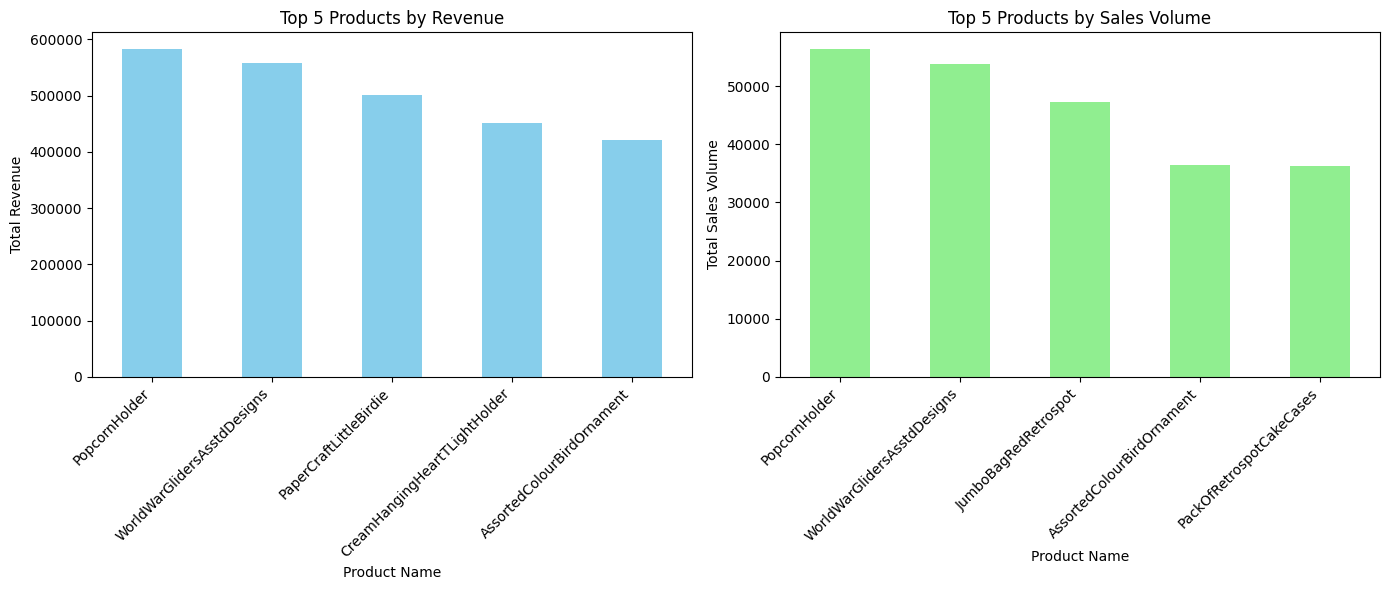

In [14]:
import matplotlib.pyplot as plt

# Calculate total revenue and sales volume for each product
product_revenue = df_pandas.groupby('productName_process')['Revenue'].sum()
product_sales_volume = df_pandas.groupby('productName_process')['Quantity'].sum()

# Get top 5 products by revenue
top5_revenue = product_revenue.nlargest(5)
top5_sales_volume = product_sales_volume.nlargest(5)

# Plot top 5 products by revenue
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
top5_revenue.plot(kind='bar', color='skyblue')
plt.title('Top 5 Products by Revenue')
plt.xlabel('Product Name')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45, ha='right')

# Plot top 5 products by sales volume
plt.subplot(1, 2, 2)
top5_sales_volume.plot(kind='bar', color='lightgreen')
plt.title('Top 5 Products by Sales Volume')
plt.xlabel('Product Name')
plt.ylabel('Total Sales Volume')
plt.xticks(rotation=45, ha='right')

# Show the plots
plt.tight_layout()
plt.show()


Q 1.4

In [15]:
# Calculate total revenue by country
revenue_by_country = df_pandas.groupby('Country')['Revenue'].sum()
highest_revenue_country = revenue_by_country.idxmax()
highest_revenue_value = revenue_by_country.max()

# Filter data for the country with the highest revenue
df_country_filtered = df_pandas[df_pandas['Country'] == highest_revenue_country]

# Extract month from 'transaction_date' and calculate total revenue by month
df_country_filtered['Month'] = df_country_filtered['transaction_date'].dt.to_period('M')  # Convert to Period for monthly aggregation
revenue_by_month = df_country_filtered.groupby('Month')['Revenue'].sum()

# Identify the month with the highest revenue in that country
highest_revenue_month = revenue_by_month.idxmax()
highest_month_revenue = revenue_by_month.max()

# Output the results
print(f"Country with the highest revenue: {highest_revenue_country} with total revenue {highest_revenue_value}")
print(f"Month with the highest revenue in {highest_revenue_country}: {highest_revenue_month} with revenue {highest_month_revenue}")


Country with the highest revenue: United Kingdom with total revenue 49994032.0
Month with the highest revenue in United Kingdom: 2019-11 with revenue 6737640.0


<ipython-input-15-1c8d104fb69b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_country_filtered['Month'] = df_country_filtered['transaction_date'].dt.to_period('M')  # Convert to Period for monthly aggregation


Q 1.5

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter data for the top customer
df_customer_filtered = df_filtered[df_filtered['CustomerNo'] == top_customer]

# Calculate total quantity purchased per product for this customer
product_quantity = df_customer_filtered.groupby('ProductName')['Quantity'].sum()

# Identify the products typically bought by this customer
top_products = product_quantity.sort_values(ascending=False)

# Output the results
print(f"Customer with the highest shopping frequency: {top_customer} with {top_customer_frequency} distinct transactions")
print("Products typically bought by this customer based on quantity:")
print(top_products)

# Limit the number of top products to display
top_n = min(10, len(top_products))  # Adjust to the number of available products
top_products_limited = top_products.head(top_n)

# Plot the limited number of top products bought by the customer
plt.figure(figsize=(14, 7))
top_products_limited.plot(kind='bar', color='skyblue')
plt.title(f'Top {top_n} Products Typically Bought by Customer {top_customer}')
plt.xlabel('Product Name')
plt.ylabel('Total Quantity Purchased')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()



NameError: name 'top_customer' is not defined

Q 1.6

Q 1.6.1

In [22]:
# Check the columns of the DataFrame
print(df_filtered.columns)


AttributeError: 'Series' object has no attribute 'columns'

In [25]:
#  Filter out transactions with quantity <= 0
df_filtered = df_pandas[df_pandas['Quantity'] > 0]

#  Remove rows with '0ca' in Product_category
df_filtered = df_filtered[df_filtered['Product_category'] != '0ca']

#  Group by 'TransactionNo' and aggregate 'Product_category' and 'ProductName' into lists
basket_summary = df_filtered.groupby('TransactionNo').agg({
    'Product_category': lambda x: list(x),
    'ProductName': lambda x: list(x)
}).reset_index()

#  Display the result
print(basket_summary.head())







  TransactionNo Product_category  \
0        536378            [1ca]   
1        536395            [1ca]   
2        536404       [1ca, 4ca]   
3        536408            [1ca]   
4        536412            [4ca]   

                                         ProductName  
0                  [Pack Of 72 Retrospot Cake Cases]  
1                  [Pack Of 72 Retrospot Cake Cases]  
2  [Pack Of 72 Retrospot Cake Cases, Lunch Bag Su...  
3                  [Pack Of 72 Retrospot Cake Cases]  
4                            [Lunch Bag Suki Design]  


Q 1.6.3

In [26]:
import pandas as pd

# Function to remove adjacent duplicates from a list
def remove_adjacent_duplicates(lst):
    return [x for i, x in enumerate(lst) if i == 0 or x != lst[i - 1]]

# Apply the function to 'Product_category' column
basket_summary['Product_category_processed'] = basket_summary['Product_category'].apply(remove_adjacent_duplicates)

# Display the top 10 rows of the processed DataFrame
print(basket_summary.head(10))

# Optionally, save the processed DataFrame to a CSV file
# basket_summary.to_csv('/content/drive/My Drive/Colab Notebooks/basket_summary_processed.csv', index=False)


  TransactionNo Product_category  \
0        536378            [1ca]   
1        536395            [1ca]   
2        536404       [1ca, 4ca]   
3        536408            [1ca]   
4        536412            [4ca]   
5        536415            [1ca]   
6        536464       [1ca, 1ca]   
7        536532            [1ca]   
8        536542            [4ca]   
9        536544       [1ca, 4ca]   

                                         ProductName  \
0                  [Pack Of 72 Retrospot Cake Cases]   
1                  [Pack Of 72 Retrospot Cake Cases]   
2  [Pack Of 72 Retrospot Cake Cases, Lunch Bag Su...   
3                  [Pack Of 72 Retrospot Cake Cases]   
4                            [Lunch Bag Suki Design]   
5                  [Pack Of 72 Retrospot Cake Cases]   
6  [Pack Of 72 Retrospot Cake Cases, Pack Of 72 R...   
7                  [Pack Of 72 Retrospot Cake Cases]   
8                            [Lunch Bag Suki Design]   
9  [Pack Of 72 Retrospot Cake Cases, Lunch 

Q 1.7

1.7.1

In [27]:
# Create a new column 'prod_lent' to find out the length of the list in 'Product_category_processed'
basket_summary['prod_lent'] = basket_summary['Product_category_processed'].apply(len)

# Print the first 5 rows of the DataFrame
print(basket_summary.head(5))


  TransactionNo Product_category  \
0        536378            [1ca]   
1        536395            [1ca]   
2        536404       [1ca, 4ca]   
3        536408            [1ca]   
4        536412            [4ca]   

                                         ProductName  \
0                  [Pack Of 72 Retrospot Cake Cases]   
1                  [Pack Of 72 Retrospot Cake Cases]   
2  [Pack Of 72 Retrospot Cake Cases, Lunch Bag Su...   
3                  [Pack Of 72 Retrospot Cake Cases]   
4                            [Lunch Bag Suki Design]   

  Product_category_processed  prod_lent  
0                      [1ca]          1  
1                      [1ca]          1  
2                 [1ca, 4ca]          2  
3                      [1ca]          1  
4                      [4ca]          1  


1.7.2

In [28]:
# Function to remove adjacent duplicates from a list
def remove_adjacent_duplicates(lst):
    return [x for i, x in enumerate(lst) if i == 0 or x != lst[i - 1]]

# Apply the function to 'Product_category' column
basket_summary['Product_category_processed'] = basket_summary['Product_category'].apply(remove_adjacent_duplicates)

# Create 'df_1' by making a copy of the processed DataFrame
df_1 = basket_summary.copy()

# Display the top 10 rows of 'df_1'
print(df_1.head(10))


  TransactionNo Product_category  \
0        536378            [1ca]   
1        536395            [1ca]   
2        536404       [1ca, 4ca]   
3        536408            [1ca]   
4        536412            [4ca]   
5        536415            [1ca]   
6        536464       [1ca, 1ca]   
7        536532            [1ca]   
8        536542            [4ca]   
9        536544       [1ca, 4ca]   

                                         ProductName  \
0                  [Pack Of 72 Retrospot Cake Cases]   
1                  [Pack Of 72 Retrospot Cake Cases]   
2  [Pack Of 72 Retrospot Cake Cases, Lunch Bag Su...   
3                  [Pack Of 72 Retrospot Cake Cases]   
4                            [Lunch Bag Suki Design]   
5                  [Pack Of 72 Retrospot Cake Cases]   
6  [Pack Of 72 Retrospot Cake Cases, Pack Of 72 R...   
7                  [Pack Of 72 Retrospot Cake Cases]   
8                            [Lunch Bag Suki Design]   
9  [Pack Of 72 Retrospot Cake Cases, Lunch 

In [30]:

def data_processing(df, maxlength=3, minlength=1):
    # Filter DataFrame based on 'prod_lent'
    df_filtered = df[(df['prod_lent'] <= maxlength) & (df['prod_lent'] >= minlength)]

    # Define a function to transform the list into the required format
    def transform_list(lst):
        if not lst:
            return ''
        return 'start > ' + ' > '.join(lst) + ' > conversion'

    # Apply the transformation function to 'Product_category_processed'
    df_filtered['path'] = df_filtered['Product_category_processed'].apply(transform_list)

    return df_filtered

# Apply the function to 'df_1' with maxlength=5 and minlength=2
df_2 = data_processing(df_1, maxlength=5, minlength=2)

# Print the top 10 rows of the new DataFrame 'df_2'
print(df_2.head(10))


   TransactionNo Product_category  \
2         536404       [1ca, 4ca]   
9         536544       [1ca, 4ca]   
37        537135       [4ca, 3ca]   
43        537227       [1ca, 4ca]   
44        537237       [1ca, 4ca]   
45        537240       [1ca, 3ca]   
58        537638       [1ca, 3ca]   
62        537646       [1ca, 4ca]   
63        537666  [3ca, 1ca, 4ca]   
72        537823       [3ca, 1ca]   

                                          ProductName  \
2   [Pack Of 72 Retrospot Cake Cases, Lunch Bag Su...   
9   [Pack Of 72 Retrospot Cake Cases, Lunch Bag Su...   
37  [Lunch Bag Suki Design, Cream Sweetheart Mini ...   
43  [Pack Of 72 Retrospot Cake Cases, Lunch Bag Su...   
44  [Pack Of 72 Retrospot Cake Cases, Lunch Bag Su...   
45  [Pack Of 72 Retrospot Cake Cases, Cream Sweeth...   
58  [Pack Of 72 Retrospot Cake Cases, Cream Sweeth...   
62  [Pack Of 72 Retrospot Cake Cases, Lunch Bag Su...   
63  [Cream Sweetheart Mini Chest, Pack Of 72 Retro...   
72  [Cream Sweetheart 

<ipython-input-30-be1b9fe5700c>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['path'] = df_filtered['Product_category_processed'].apply(transform_list)


Q 1.8


In [31]:
import pandas as pd

# Assuming df_2 is already defined and contains the transaction data

# Step 1: Define the patterns to check
patterns = ['0ca', '1ca', '2ca', '3ca', '4ca']

# Initialize a dictionary to hold the results
results = {}

# Step 2: Loop through each pattern and count the transactions
for pattern in patterns:
    # Create a pattern string to check for
    pattern_str = f">{pattern}>conversion"

    # Count the transactions that end with the pattern
    count = df_2[df_2['Product_category'].apply(lambda x: str(x).endswith(pattern_str))].shape[0]

    # Store the result in the dictionary
    results[pattern] = count

# Step 3: Display the results
for pattern, count in results.items():
    print(f"Number of transactions ending with pattern '...>{pattern}>conversion': {count}")


Number of transactions ending with pattern '...>0ca>conversion': 0
Number of transactions ending with pattern '...>1ca>conversion': 0
Number of transactions ending with pattern '...>2ca>conversion': 0
Number of transactions ending with pattern '...>3ca>conversion': 0
Number of transactions ending with pattern '...>4ca>conversion': 0


# PART II

### 2.1

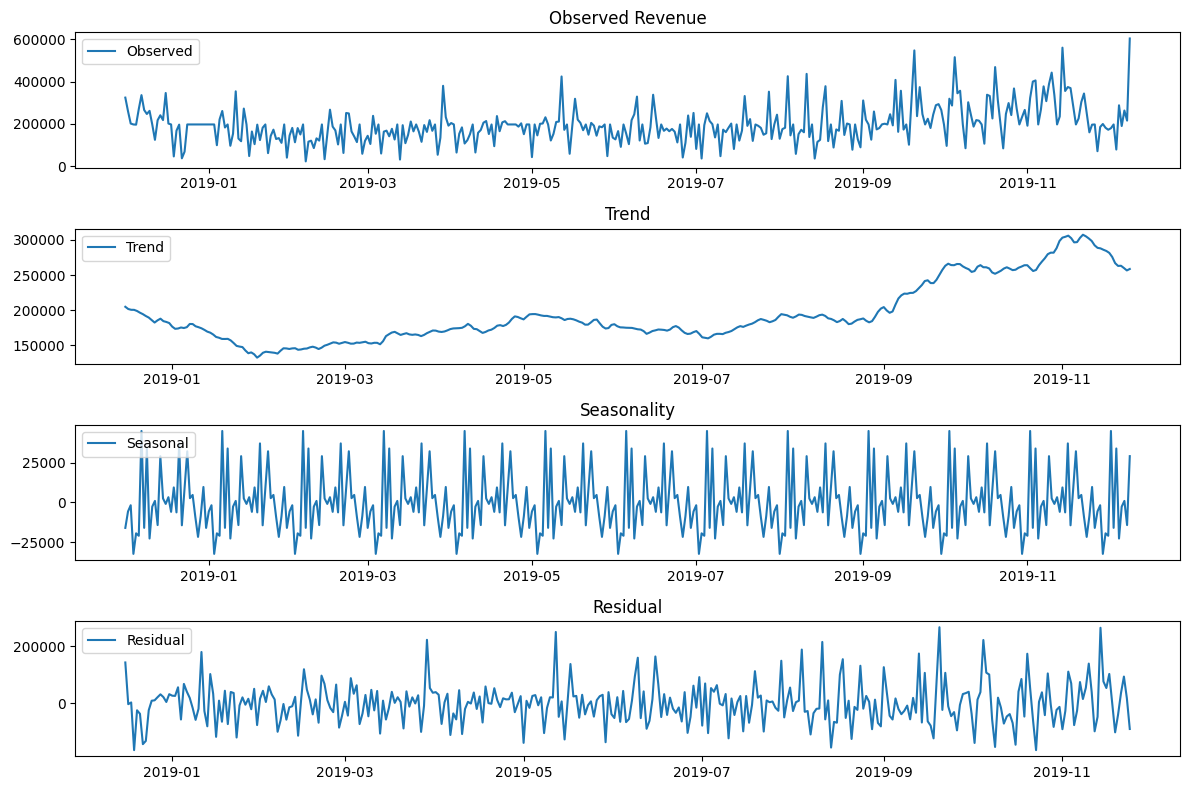

In [19]:
# Required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Step 1: Use the existing 'revenue_by_date' from Task 1.2 (ensure transaction_date is in datetime format)
# If not already in the format, convert the 'transaction_date' column to datetime
df_pandas['transaction_date'] = pd.to_datetime(df_pandas['transaction_date'], format='%Y-%m-%d')

# Group by 'transaction_date' and sum the 'Revenue'
revenue_by_date = df_pandas.groupby('transaction_date')['Revenue'].sum()

# Step 2: Add missing dates to the time series
# Create a date range that covers the entire period of the transaction data
full_date_range = pd.date_range(start=revenue_by_date.index.min(), end=revenue_by_date.index.max(), freq='D')

# Reindex the revenue_by_date to include all dates in the full_date_range
revenue_by_date = revenue_by_date.reindex(full_date_range, fill_value=np.nan)

# Step 3: Calculate the mean revenue
mean_revenue = revenue_by_date.mean()

# Fill missing values with the calculated mean revenue
revenue_by_date.fillna(mean_revenue, inplace=True)

# Step 4: Decompose the time series using additive decomposition
# Perform decomposition with an additive model, default settings
decomposition = seasonal_decompose(revenue_by_date, model='additive', period=30)

# Plot the decomposed components
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.title('Observed Revenue')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.title('Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.title('Seasonality')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.title('Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()



**Steps Explanation:**
1. Reindex the time series to include all missing dates and fill those gaps with the mean revenue.
2. Decompose the time series into its observed, trend, seasonal, and residual components using an additive model.
3. Plot the decomposed components to visually analyze any seasonality patterns.

**Observed Revenue:** This is the raw time series of the total revenue per transaction date. You can see fluctuations throughout 2019, with some spikes around May and near the end of the year.

**Trend:** This component smooths out short-term variations to show the overall direction. It reveals an upward trend starting in mid-2019, peaking around November, and slightly declining afterward.

**Seasonality:** The seasonal component shows regular patterns repeating over a fixed period, which, in this case, seems to display cycles every month or so. You can observe alternating peaks and troughs that suggest there is indeed a recurring seasonal pattern.

**Residual:** These are the remaining fluctuations after removing the trend and seasonality. These could represent irregular factors or noise in the data.

**Insights:**
* Seasonality: The decomposition suggests there is a seasonal pattern in the
revenue data. This could indicate regular fluctuations tied to factors like customer behavior or business cycles, such as higher revenues around certain times of the month or year.
* Trend: The upward trend indicates that revenue was increasing throughout 2019, peaking near November, which might reflect stronger sales in Q4, possibly linked to holiday shopping.

#### 2.2

ARIMA(0, 0, 0) - MAE: 102504.6062008424
ARIMA(0, 0, 1) - MAE: 102468.43938033961
ARIMA(0, 0, 2) - MAE: 102326.4656910903
ARIMA(0, 1, 0) - MAE: 90887.43509615384
ARIMA(0, 1, 1) - MAE: 90402.01071950016
ARIMA(0, 1, 2) - MAE: 90399.25596466732
ARIMA(0, 2, 0) - MAE: 664317.0088141026


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 2, 1) - MAE: 97147.20453488678
ARIMA(0, 2, 2) - MAE: 98016.13062565462
ARIMA(1, 0, 0) - MAE: 102504.12975776405
ARIMA(1, 0, 1) - MAE: 89061.87575274488
ARIMA(1, 0, 2) - MAE: 102229.20397733292
ARIMA(1, 1, 0) - MAE: 90235.88236181691
ARIMA(1, 1, 1) - MAE: 90400.76196948967


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1, 1, 2) - MAE: 90391.0195364633
ARIMA(1, 2, 0) - MAE: 678127.3497138594
ARIMA(1, 2, 1) - MAE: 95153.85206099424


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1, 2, 2) - MAE: 97100.35010609907
ARIMA(2, 0, 0) - MAE: 102074.30541659272
ARIMA(2, 0, 1) - MAE: 102118.0854594909
ARIMA(2, 0, 2) - MAE: 102567.11903153794
ARIMA(2, 1, 0) - MAE: 90300.4164804594
ARIMA(2, 1, 1) - MAE: 90388.09837984019


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 1, 2) - MAE: 90396.78944247011
ARIMA(2, 2, 0) - MAE: 285311.7587533127
ARIMA(2, 2, 1) - MAE: 93725.3884299468


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 2, 2) - MAE: 95319.16741970138
Best ARIMA order: (1, 0, 1) with MAE: 89061.87575274488


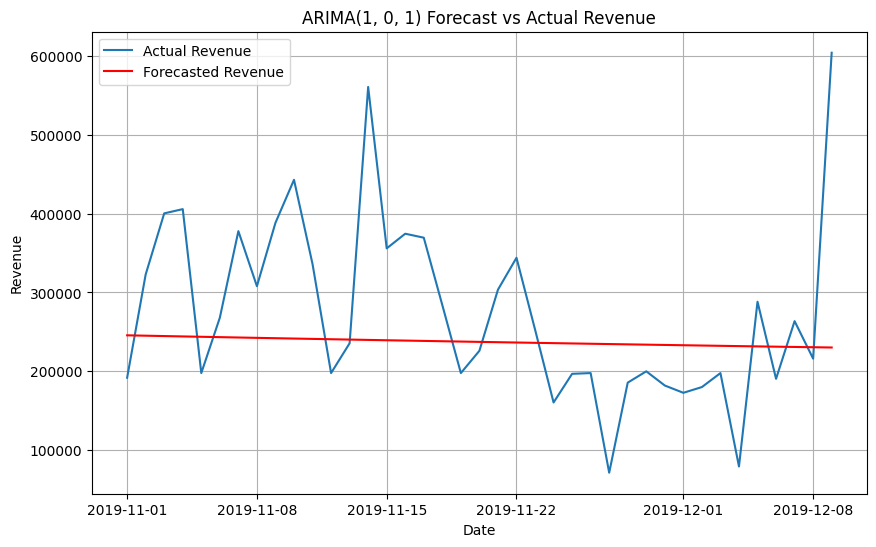

In [20]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
import itertools

# Use the same data as in the previous question, filtered for dates up to 'Nov-01-2019'
df_filtered = revenue_by_date['2019-01-01':'2019-11-01']

# Split the data into training and testing sets (training until Nov 1, 2019)
train_data = df_filtered[:'2019-10-31']
test_data = revenue_by_date['2019-11-01':]

# Define the parameter ranges for p, d, and q
p = d = q = range(0, 3)  # p, d, q can be 0, 1, or 2
pdq = list(itertools.product(p, d, q))  # Create all combinations of p, d, q

# Store the best model and the lowest MAE
best_mae = np.inf
best_order = None
best_model = None

# Grid search over ARIMA parameters
for param in pdq:
    try:
        # Fit the ARIMA model
        model = ARIMA(train_data, order=param)
        model_fit = model.fit()

        # Forecast on the test set
        forecast = model_fit.forecast(steps=len(test_data))

        # Calculate MAE
        mae = mean_absolute_error(test_data, forecast)

        # Check if this model has the lowest MAE
        if mae < best_mae:
            best_mae = mae
            best_order = param
            best_model = model_fit
        print(f"ARIMA{param} - MAE: {mae}")
    except Exception as e:
        print(f"ARIMA{param} failed: {e}")
        continue

# Print the best model and its MAE
print(f"Best ARIMA order: {best_order} with MAE: {best_mae}")

# Plot the predictions from the best model
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(test_data.index, test_data, label='Actual Revenue')
plt.plot(test_data.index, best_model.forecast(steps=len(test_data)), label='Forecasted Revenue', color='red')
plt.title(f"ARIMA{best_order} Forecast vs Actual Revenue")
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.show()


**Chosen Solution:** I implemented ARIMA using grid search for parameters
p, d, and q (range [0,1,2]) to find the best model with the lowest Mean Absolute Error (MAE). This approach allowed a systematic evaluation of 27 combinations.

**Other Solutions:** Other models like SARIMA or advanced deep learning models (LSTM/GRU) could also be used to solve the task, especially for capturing more complex seasonality.

**Optimality:** The solution is optimal within the scope of ARIMA-based models since I performed a complete grid search. However, using SARIMA could further optimize results if seasonality exists.

### **2.3 Data Wrangling and Modeling Steps for Deep Learning Time Series Forecasting**

#### **Data Wrangling Steps:**

**Data Preparation:**

* Convert the time series data into a supervised learning problem by creating features from lagged observations. For example, create a dataset where the target is revenue at time t, and features are revenue values at times t−1, t−2, etc.
* Normalize or standardize the data using MinMaxScaler or StandardScaler to ensure that the deep learning model converges faster.

**Train-Test Split:**

* Split the time series data into training and testing datasets based on time (e.g., using data from 2019-01 to 2019-10 for training, and data from 2019-11 for testing).

**Data Reshaping:**

* Reshape the data into the format expected by deep learning models like LSTM, which requires a 3D input format: (samples, timesteps, features). For a univariate time series, the feature dimension would be 1.

**Handling Missing Values:**

* Impute missing values if any using forward fill, backward fill, or interpolation methods.

#### **Modeling Steps:**
**Model Selection:**

* **LSTM (Long Short-Term Memory):**
  * LSTM networks are ideal for capturing long-term dependencies in time series data.
  * Architecture: Sequential model with LSTM layers, followed by Dense layers for output.
* **GRU (Gated Recurrent Unit):**
  * GRU is a simplified version of LSTM, which can be more efficient with similar performance for certain datasets.
* **CNN-LSTM:**
  * A combination of Convolutional Neural Networks (CNN) to extract features from the time series, followed by LSTM to capture temporal dependencies.
* **N-BEATS (Neural Basis Expansion Analysis):**
  * An advanced architecture specifically designed for time-series forecasting that combines fully connected layers and interpretable blocks.

#### **Model Architecture:**

* Stack multiple LSTM/GRU layers with a dropout layer in between to prevent overfitting.
* Add Dense layers for forecasting the revenue at the next timestep.
* For CNN-LSTM, use Conv1D layers before feeding the output to an LSTM layer.

#### **Model Compilation:**

* Use mean absolute error (MAE) or mean squared error (MSE) as the loss function.
* Choose Adam optimizer due to its adaptive learning rate properties.

#### **Training:**

* Use early stopping and model checkpointing to avoid overfitting and save the best-performing model.
* Train on batches of data to ensure efficient learning for large datasets.

#### **Evaluation:**

* Compare the performance of each deep learning model using MAE, MSE, or RMSE metrics.
* Plot the forecasted vs. actual revenue values to visualize the accuracy.

#### **References:**
* **LSTM and GRU:** Hochreiter, S., & Schmidhuber, J. (1997). Long short-term memory. Neural Computation, 9(8), 1735-1780.
* **CNN-LSTM:** Shi, X., et al. (2015). Convolutional LSTM Network: A Machine Learning Approach for Precipitation Nowcasting. arXiv preprint arXiv:1506.04214.
* **N-BEATS:** Oreshkin, B. N., et al. (2019). N-BEATS: Neural Basis Expansion Analysis for Time Series Forecasting. arXiv preprint arXiv:1905.10437.